In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy

In [1]:
import sympy as sp
sp.init_printing()

In [3]:
sp_t = sp.symbols('t', real=True) #sp_theta = sp.Function('theta', real=True)(sp_t)
sp_f_ref =sp.sin(sp_t)**2 #sp.sin(sp_t)
sp_f_ref,sp.diff(sp_f_ref,sp_t),sp.diff(sp_f_ref,sp_t,2)

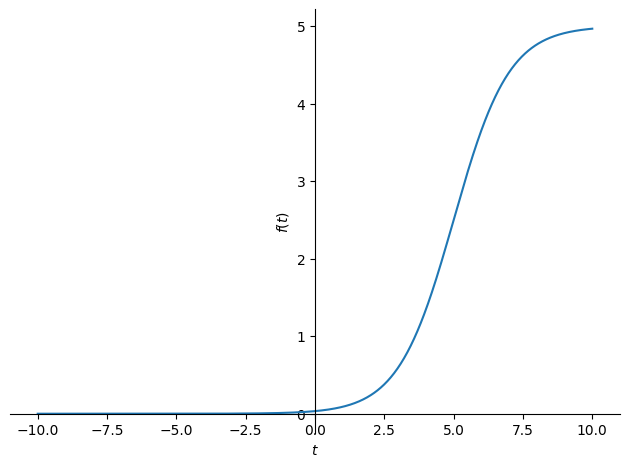

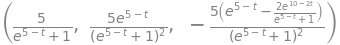

In [37]:
sp_f_ref = 1/(1 + sp.exp(-sp_t + 5)) * 5
sp.plot(sp_f_ref,(sp_t,-10,10))
sp_f_ref,sp.diff(sp_f_ref,sp_t),sp.diff(sp_f_ref,sp_t,2)

In [38]:
print( sp_f_ref) 
print( sp.diff(sp_f_ref,sp_t))
print( sp.diff(sp_f_ref,sp_t,2))    

5/(exp(5 - t) + 1)
5*exp(5 - t)/(exp(5 - t) + 1)**2
-5*(exp(5 - t) - 2*exp(10 - 2*t)/(exp(5 - t) + 1))/(exp(5 - t) + 1)**2


In [62]:


# Parámetros del sistema
m = 1.0     # masa (kg)
l = 1.0     # longitud (m)
g = 9.81    # gravedad (m/s²)
b = 0.1     # fricción (N⋅m⋅s/rad)


# Parámetros de simulación
T = 0.01    # período de muestreo (s)
t_final = 10  # tiempo final de simulación (s)
k_steps = int(t_final/T)  # número de pasos
n_edos = 2  # número de ecuaciones diferenciales

# Vectores para almacenar resultados
t = np.arange(0, t_final, T)  # vector de tiempo

# Sistema sin ruido
theta = np.zeros(k_steps)      # ángulo
theta_dot = np.zeros(k_steps)  # velocidad angular
# Sistema sin ruido medicion
theta_ruido_medicion = np.zeros(k_steps)      # ángulo
theta_ruido_medicion_dot = np.zeros(k_steps)  # velocidad angular
# Sistema con ruido de proceso
theta_ruido_proceso = np.zeros(k_steps)      # ángulo
theta_ruido_proceso_dot = np.zeros(k_steps)  # velocidad angular
# Sistema con ruido de proceso y medicion 
theta_ruido_medicion_proceso = np.zeros(k_steps)      # ángulo
theta_ruido_medicion_proceso_dot = np.zeros(k_steps)  # velocidad angular

# Condiciones iniciales
theta[0] = np.pi/4    # 45 grados
theta_dot[0] = 0      # velocidad inicial cero
theta_ruido_medicion[0] = np.pi/4    # 45 grados
theta_ruido_medicion_dot[0] = 0      # velocidad inicial cero
theta_ruido_proceso[0] = np.pi/4    # 45 grados
theta_ruido_proceso_dot[0] = 0      # velocidad inicial cero
theta_ruido_medicion_proceso[0] = np.pi/4    # 45 grados
theta_ruido_medicion_proceso_dot[0] = 0      # velocidad inicial cero

# Calcular referencia
theta_ref = 1/(np.exp(5 - t) + 1) #np.sin(t)
dtheta_ref = np.exp(5 - t)/(np.exp(5 - t) + 1)**2 #np.cos(t)
ddtheta_ref = (-np.exp(5 - t) + 2*np.exp(10 - 2*t)/(np.exp(5 - t) + 1))/(np.exp(5 - t) + 1)**2 #-np.sin(t) 



def control_retroalimentacion(estado, t):
    #theta_ref = np.sin(t)
    #dtheta_ref = np.cos(t)  
    #ddtheta_ref = -np.sin(t)  
    theta_ref = 1/(np.exp(5 - t) + 1) #np.sin(t)
    dtheta_ref = np.exp(5 - t)/(np.exp(5 - t) + 1)**2 #np.cos(t)
    ddtheta_ref = (-np.exp(5 - t) + 2*np.exp(10 - 2*t)/(np.exp(5 - t) + 1))/(np.exp(5 - t) + 1)**2 #-np.sin(t) 
    
    theta,dtheta = estado+ np.random.normal(0,0.002,(estado.shape) )
    k1,k2 = 10,20 #2,1
    
    e = theta - theta_ref  # Error
    de = dtheta - dtheta_ref  # Derivada del error

    u = m*l**2*( ddtheta_ref - k1*(de) -k2*(e) + (b/(m*l**2))*dtheta + (g/l)*np.sin(theta) )  # Control
    return u  

def system (x,u,ruido=0):
    theta = x[0]
    theta_dot = x[1]

    dtheta = theta_dot + ruido[0]
    dtheta_dot = (-b*theta_dot - m*g*l*np.sin(theta) + u)/(m*l**2) + ruido[1]

    theta_k1 = theta + T*dtheta
    theta_dot_k1 = theta_dot + T*dtheta_dot

    return np.array([theta_k1, theta_dot_k1])


np.random.seed(158)
#ruido_medicion = cauchy.rvs(loc=0, scale=0.01, size=(k_steps,n_edos)) #np.random.normal(0,0.1,(k_steps,n_edos) )
#ruido_medicion_proceso = cauchy.rvs(loc=0, scale=0.05, size=(k_steps,n_edos)) #np.random.normal(0,0.15,(k_steps,n_edos) )

ruido_medicion = np.random.normal(0,0.1,(k_steps,n_edos) )
ruido_medicion_proceso = np.random.normal(0,0.15,(k_steps,n_edos) )
# Simulación usando método de Euler
for k in range(k_steps-1):
    # Entrada de control (en este caso 0 para oscilación libre)
    #u = 0#control_retroalimentacion([theta[k], theta_dot[k]], t[k])

    # Sistema sin ruido
    x = np.array([theta[k], theta_dot[k]])
    z = x
    u = control_retroalimentacion(z, t[k])
    theta[k+1], theta_dot[k+1] = system([theta[k], theta_dot[k]], u, [0,0] )

    # Sistema con ruido de medicion 
    x = np.array([theta_ruido_medicion[k], theta_ruido_medicion_dot[k]])
    z = x + ruido_medicion[k,:]
    u = control_retroalimentacion(z, t[k])
    theta_ruido_medicion[k+1], theta_ruido_medicion_dot[k+1] = system([theta_ruido_medicion[k], theta_ruido_medicion_dot[k]], u, [0,0] )

    # Sistema con ruido de proceso
    x = np.array([theta_ruido_proceso[k], theta_ruido_proceso_dot[k]])
    z = x 
    u = control_retroalimentacion(z, t[k])
    theta_ruido_proceso[k+1], theta_ruido_proceso_dot[k+1] = system([theta_ruido_proceso[k], theta_ruido_proceso_dot[k]], u, ruido_medicion_proceso[k,:] )

    # Sistema con ruido de meidcion y proceso
    x = np.array([theta_ruido_medicion_proceso[k], theta_ruido_medicion_proceso_dot[k]])
    z = x + ruido_medicion[k,:]
    u = control_retroalimentacion(z, t[k])
    theta_ruido_medicion_proceso[k+1], theta_ruido_medicion_proceso_dot[k+1] = system([theta_ruido_medicion_proceso[k], theta_ruido_medicion_proceso_dot[k]], u, ruido_medicion_proceso[k,:] )




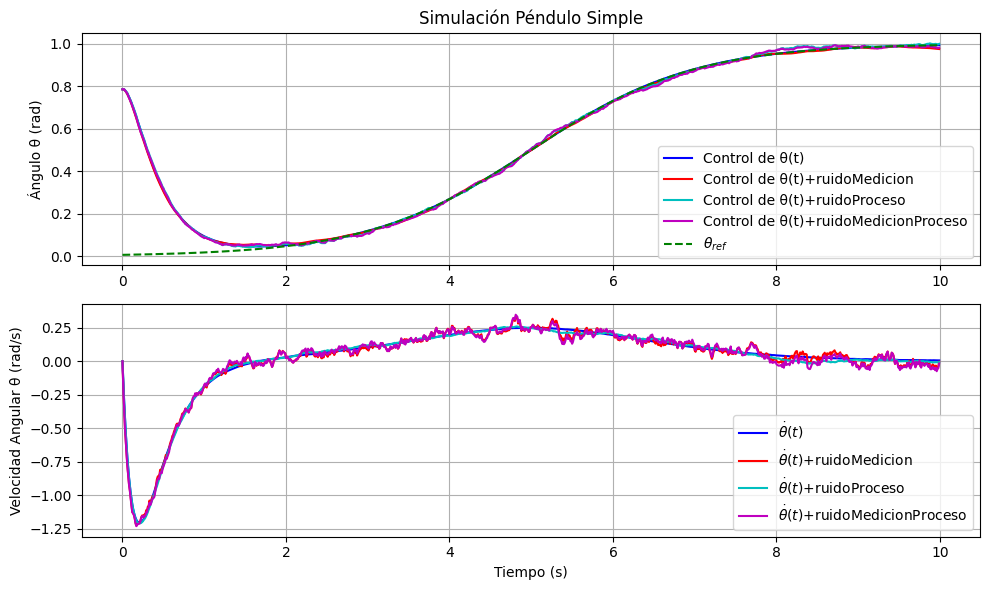

In [63]:
# Graficar resultados
plt.figure(figsize=(10, 6))

# Gráfica del ángulo
plt.subplot(2,1,1)
plt.plot(t, theta, 'b-', label='Control de θ(t)')
plt.plot(t, theta_ruido_medicion, 'r-', label='Control de θ(t)+ruidoMedicion')
plt.plot(t, theta_ruido_proceso, 'c-', label='Control de θ(t)+ruidoProceso')
plt.plot(t, theta_ruido_medicion_proceso, 'm-', label='Control de θ(t)+ruidoMedicionProceso')
plt.plot(t, theta_ref, 'g--',label='$θ_{ref}$')

plt.legend(['θ','θ+ruido', '$θ_{ref}$'])
plt.grid(True)
plt.ylabel('Ángulo θ (rad)')
plt.title('Simulación Péndulo Simple')
plt.legend()

# Gráfica de la velocidad angular
plt.subplot(2,1,2)
plt.plot(t, theta_dot, 'b-', label='$\\dot{θ̇}(t)$')
plt.plot(t, theta_ruido_medicion_dot, 'r-', label='$\\dot{θ̇}(t)$+ruidoMedicion')
plt.plot(t, theta_ruido_proceso_dot, 'c-', label='$\\dot{θ̇}(t)$+ruidoProceso')
plt.plot(t, theta_ruido_medicion_proceso_dot, 'm-', label='$\\dot{θ̇}(t)$+ruidoMedicionProceso')
plt.grid(True)
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad Angular θ̇ (rad/s)')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
import plotly.graph_objects as go

# Sistema con ruido

In [64]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Crear los subplots
fig = make_subplots(rows=2, cols=1, 
                   subplot_titles=('Ángulo del Péndulo', 'Velocidad Angular'),
                   vertical_spacing=0.15)

# Gráfica del ángulo (primera subfigura)
fig.add_trace(
   go.Scatter(
       x=t,
       y=theta,
       name='θ',
       line=dict(color='blue'),
       #legendgroup='1'
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_medicion,
       name='θ+ruido medición',
       line=dict(color='red'),
       #legendgroup='1'
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_proceso,
       name='θ+ruido proceso',
       line=dict(color='cyan'),
       #legendgroup='1'
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_medicion_proceso,
       name='θ+ruido medición+proceso',
       line=dict(color='magenta'),
       #legendgroup='1'
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ref,
       name='θ_ref',
       line=dict(color='green', dash='dash'),
       #legendgroup='1'
   ),
   row=1, col=1
)

# Gráfica de la velocidad angular (segunda subfigura)
fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_dot,
       name='ω',
       line=dict(color='blue'),
       #legendgroup='2',
       showlegend=True
   ),
   row=2, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_medicion_dot,
       name='ω+ruido medición',
       line=dict(color='red'),
       #legendgroup='2',
       showlegend=True
   ),
   row=2, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_proceso_dot,
       name='ω+ruido proceso',
       line=dict(color='cyan'),
       #legendgroup='2',
       showlegend=True
   ),
   row=2, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_medicion_proceso_dot,
       name='ω+ruido medición+proceso',
       line=dict(color='magenta'),
       #legendgroup='2',
       showlegend=True
   ),
   row=2, col=1
)

# Actualizar layout
fig.update_layout(
   title='Simulación Péndulo Simple',
   height=800,  # Altura total de la figura
   showlegend=True,
   plot_bgcolor='white',  # Fondo blanco
   legend=dict(
       yanchor="top",
       y=0.99,
       xanchor="left",
       x=1.05
   ),
   #hovermode='x unified'  # Mostrar todos los valores para un mismo x
   hovermode='x unified'  # Mostrar todos los valores para un mismo x
)

# Actualizar ejes y cuadrícula
for i in [1, 2]:
   fig.update_xaxes(
       showgrid=True,
       gridwidth=1,
       gridcolor='LightGray',
       zeroline=True,
       zerolinewidth=2,
       zerolinecolor='LightGray',
       row=i,
       col=1
   )
   fig.update_yaxes(
       showgrid=True,
       gridwidth=1,
       gridcolor='LightGray',
       zeroline=True,
       zerolinewidth=2,
       zerolinecolor='LightGray',
       row=i,
       col=1
   )

# Actualizar títulos de los ejes
fig.update_xaxes(title_text='Tiempo (s)', row=2, col=1)
fig.update_yaxes(title_text='Ángulo θ (rad)', row=1, col=1)
fig.update_yaxes(title_text='Velocidad Angular θ̇ (rad/s)', row=2, col=1)


# Mostrar la figura
fig.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [50]:


# Calcular posiciones x,y de los péndulos
l = 1.0  # longitud del péndulo

# Calcular posiciones para cada péndulo
x_pendulo = l * np.sin(theta)
y_pendulo = -l * np.cos(theta)

x_pendulo_ruido_med = l * np.sin(theta_ruido_medicion)
y_pendulo_ruido_med = -l * np.cos(theta_ruido_medicion)

x_pendulo_ruido_proc = l * np.sin(theta_ruido_proceso)
y_pendulo_ruido_proc = -l * np.cos(theta_ruido_proceso)

x_pendulo_ruido_med_proc = l * np.sin(theta_ruido_medicion_proceso)
y_pendulo_ruido_med_proc = -l * np.cos(theta_ruido_medicion_proceso)

# Crear figura con subplots
fig = make_subplots(
   rows=2, cols=2,
   subplot_titles=('Péndulo Sin Ruido', 'Péndulo con Ruido de Medición',
                  'Péndulo con Ruido de Proceso', 'Péndulo con Ruido de Medición y Proceso'),
   specs=[[{'type': 'scatter'}, {'type': 'scatter'}],
          [{'type': 'scatter'}, {'type': 'scatter'}]]
)

# Crear frames para la animación
frames = []
for i in range(0,len(t),10):
   frame_data = [
       # Péndulo sin ruido
       go.Scatter(
           x=[0, x_pendulo[i]],
           y=[0, y_pendulo[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'blue']),
           line=dict(color='black', width=2),
           showlegend=False,
           name='Sin Ruido'
       ),
       
       # Péndulo con ruido de medición
       go.Scatter(
           x=[0, x_pendulo_ruido_med[i]],
           y=[0, y_pendulo_ruido_med[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'red']),
           line=dict(color='black', width=2),
           showlegend=False,
           name='Ruido Medición'
       ),
       
       # Péndulo con ruido de proceso
       go.Scatter(
           x=[0, x_pendulo_ruido_proc[i]],
           y=[0, y_pendulo_ruido_proc[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'cyan']),
           line=dict(color='black', width=2),
           showlegend=False,
           name='Ruido Proceso'
       ),
       
       # Péndulo con ambos ruidos
       go.Scatter(
           x=[0, x_pendulo_ruido_med_proc[i]],
           y=[0, y_pendulo_ruido_med_proc[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'magenta']),
           line=dict(color='black', width=2),
           showlegend=False,
           name='Ruido Med+Proc'
       )
   ]
   frames.append(go.Frame(data=frame_data, name=f'frame{i}'))

# Añadir trazos iniciales
# Péndulo sin ruido
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo[0]],
       y=[0, y_pendulo[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'blue']),
       line=dict(color='black', width=2),
       name='Sin Ruido'
   ),
   row=1, col=1
)

# Péndulo con ruido de medición
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo_ruido_med[0]],
       y=[0, y_pendulo_ruido_med[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'red']),
       line=dict(color='black', width=2),
       name='Ruido Medición'
   ),
   row=1, col=2
)

# Péndulo con ruido de proceso
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo_ruido_proc[0]],
       y=[0, y_pendulo_ruido_proc[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'cyan']),
       line=dict(color='black', width=2),
       name='Ruido Proceso'
   ),
   row=2, col=1
)

# Péndulo con ambos ruidos
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo_ruido_med_proc[0]],
       y=[0, y_pendulo_ruido_med_proc[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'magenta']),
       line=dict(color='black', width=2),
       name='Ruido Med+Proc'
   ),
   row=2, col=2
)

# Actualizar layout
fig.update_layout(
   title='Simulación de Péndulos con Diferentes Tipos de Ruido',
   height=800,
   width=1000,
   showlegend=True,
   plot_bgcolor='white',
   updatemenus=[
       {
           "buttons": [
               {
                   "args": [None, {"frame": {"duration": 50, "redraw": True},
                                 "fromcurrent": True}],
                   "label": "Play",
                   "method": "animate"
               },
               {
                   "args": [[None], {"frame": {"duration": 0, "redraw": True},
                                   "mode": "immediate",
                                   "transition": {"duration": 0}}],
                   "label": "Pause",
                   "method": "animate"
               }
           ],
           "direction": "left",
           "pad": {"r": 10, "t": 10},
           "type": "buttons",
           "x": 0.1,
           "y": 0
       }
   ],
   sliders=[{
       "currentvalue": {"prefix": "Tiempo: "},
       "pad": {"b": 10, "t": 50},
       "len": 0.9,
       "x": 0.1,
       "y": 0,
       "steps": [
           {
               "args": [[f.name], {
                   "frame": {"duration": 0, "redraw": True},
                   "mode": "immediate",
                   "transition": {"duration": 0}
               }],
               "label": str(round(t[k], 2)),
               "method": "animate"
           } for k, f in enumerate(frames)
       ]
   }]
)

# Actualizar ejes para todas las subgráficas
for i in [1, 2]:
   for j in [1, 2]:
       fig.update_xaxes(range=[-1.5, 1.5], row=i, col=j, showgrid=True, gridcolor='LightGray')
       fig.update_yaxes(range=[-1.5, 1.5], row=i, col=j, showgrid=True, gridcolor='LightGray')
       fig.update_yaxes(scaleanchor=f'x{(i-1)*2 + j}', scaleratio=1, row=i, col=j)

# Actualizar frames
fig.frames = frames

# Mostrar figura
fig.show()

In [52]:
import plotly.graph_objects as go
import numpy as np

# Calcular posiciones x,y de los péndulos
l = 1.0  # longitud del péndulo

# Calcular posiciones para cada péndulo
x_pendulo = l * np.sin(theta)
y_pendulo = -l * np.cos(theta)

x_pendulo_ruido_med = l * np.sin(theta_ruido_medicion)
y_pendulo_ruido_med = -l * np.cos(theta_ruido_medicion)

x_pendulo_ruido_proc = l * np.sin(theta_ruido_proceso)
y_pendulo_ruido_proc = -l * np.cos(theta_ruido_proceso)

x_pendulo_ruido_med_proc = l * np.sin(theta_ruido_medicion_proceso)
y_pendulo_ruido_med_proc = -l * np.cos(theta_ruido_medicion_proceso)

# Crear figura
fig = go.Figure()

# Crear frames para la animación
frames = []
for i in range(0,len(t),10):
   frame_data = [
       # Péndulo sin ruido
       go.Scatter(
           x=[0, x_pendulo[i]],
           y=[0, y_pendulo[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'blue']),
           line=dict(color='black', width=2),
           name='Sin Ruido'
       ),
       
       # Péndulo con ruido de medición
       go.Scatter(
           x=[0, x_pendulo_ruido_med[i]],
           y=[0, y_pendulo_ruido_med[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'red']),
           line=dict(color='black', width=2),
           name='Ruido Medición'
       ),
       
       # Péndulo con ruido de proceso
       go.Scatter(
           x=[0, x_pendulo_ruido_proc[i]],
           y=[0, y_pendulo_ruido_proc[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'cyan']),
           line=dict(color='black', width=2),
           name='Ruido Proceso'
       ),
       
       # Péndulo con ambos ruidos
       go.Scatter(
           x=[0, x_pendulo_ruido_med_proc[i]],
           y=[0, y_pendulo_ruido_med_proc[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'magenta']),
           line=dict(color='black', width=2),
           name='Ruido Med+Proc'
       )
   ]
   frames.append(go.Frame(data=frame_data, name=f'frame{i}'))

# Añadir trazos iniciales
# Péndulo sin ruido
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo[0]],
       y=[0, y_pendulo[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'blue']),
       line=dict(color='black', width=2),
       name='Sin Ruido'
   )
)

# Péndulo con ruido de medición
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo_ruido_med[0]],
       y=[0, y_pendulo_ruido_med[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'red']),
       line=dict(color='black', width=2),
       name='Ruido Medición'
   )
)

# Péndulo con ruido de proceso
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo_ruido_proc[0]],
       y=[0, y_pendulo_ruido_proc[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'cyan']),
       line=dict(color='black', width=2),
       name='Ruido Proceso'
   )
)

# Péndulo con ambos ruidos
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo_ruido_med_proc[0]],
       y=[0, y_pendulo_ruido_med_proc[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'magenta']),
       line=dict(color='black', width=2),
       name='Ruido Med+Proc'
   )
)

# Actualizar layout
fig.update_layout(
   title='Simulación del Péndulo Simple con Diferentes Tipos de Ruido',
   height=800,
   width=800,
   showlegend=True,
   plot_bgcolor='white',
   xaxis=dict(
       range=[-1.5, 1.5],
       showgrid=True,
       gridcolor='LightGray',
       zeroline=True,
       zerolinecolor='LightGray'
   ),
   yaxis=dict(
       range=[-1.5, 1.5],
       showgrid=True,
       gridcolor='LightGray',
       zeroline=True,
       zerolinecolor='LightGray',
       scaleanchor='x',
       scaleratio=1
   ),
   updatemenus=[
       {
           "buttons": [
               {
                   "args": [None, {"frame": {"duration": 50, "redraw": True},
                                 "fromcurrent": True}],
                   "label": "Play",
                   "method": "animate"
               },
               {
                   "args": [[None], {"frame": {"duration": 0, "redraw": True},
                                   "mode": "immediate",
                                   "transition": {"duration": 0}}],
                   "label": "Pause",
                   "method": "animate"
               }
           ],
           "direction": "left",
           "pad": {"r": 10, "t": 10},
           "type": "buttons",
           "x": 0.1,
           "y": 0
       }
   ],
   sliders=[{
       "currentvalue": {
           "prefix": "Tiempo: ",
           "suffix": " s",
           "visible": True,
           "xanchor": "right"
       },
       "pad": {"b": 10, "t": 50},
       "len": 0.9,
       "x": 0.1,
       "y": 0,
       "steps": [
           {
               "args": [[f.name], {
                   "frame": {"duration": 0, "redraw": True},
                   "mode": "immediate",
                   "transition": {"duration": 0}
               }],
               "label": f"{t[k]:.2f}",
               "method": "animate"
           } for k, f in enumerate(frames)
       ]
   }]
)

# Añadir referencia del ángulo deseado
for i in range(len(frames)):
   frames[i].data += (
       go.Scatter(
           x=[0, l*np.sin(theta_ref[i])],
           y=[0, -l*np.cos(theta_ref[i])],
           mode='lines',
           line=dict(color='green', width=2, dash='dash'),
           name='Referencia',
           showlegend=False if i > 0 else True
       ),
   )

fig.add_trace(
   go.Scatter(
       x=[0, l*np.sin(theta_ref[0])],
       y=[0, -l*np.cos(theta_ref[0])],
       mode='lines',
       line=dict(color='green', width=2, dash='dash'),
       name='Referencia'
   )
)

# Actualizar frames
fig.frames = frames

# Mostrar figura
fig.show()

# Añadiendo ruido de medicion

In [37]:
# Crear los subplots
fig = make_subplots(rows=1, cols=1, 
                   subplot_titles=('Angulo del Péndulo'),
                   vertical_spacing=0.15)

# Gráfica del ángulo (primera subfigura)
fig.add_trace(
   go.Scatter(
       x=t,
       y=theta,
       name='θ',
       line=dict(color='blue'),
       legendgroup='1'
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_medicion,
       name='θ+ruido medición',
       line=dict(color='red'),
       legendgroup='1'
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_proceso,
       name='θ+ruido proceso',
       line=dict(color='cyan'),
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_medicion_proceso,
       name='θ+ruido medición+proceso',
       line=dict(color='magenta'),
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ref,
       name='θ_ref',
       line=dict(color='green', dash='dash'),
   ),
   row=1, col=1
)


# Actualizar layout
fig.update_layout(
   title='Simulación Péndulo Simple',
   height=800,  # Altura total de la figura
   showlegend=True,
   plot_bgcolor='white',  # Fondo blanco
   legend=dict(
       yanchor="top",
       y=0.99,
       xanchor="left",
       x=1.05
   )#,
   #hovermode='x unified'  # Mostrar todos los valores para un mismo x
   #hovermode='x unified'  # Mostrar todos los valores para un mismo x
)

# Actualizar ejes y cuadrícula
for i in [1, 2]:
   fig.update_xaxes(
       showgrid=True,
       gridwidth=1,
       gridcolor='LightGray',
       zeroline=True,
       zerolinewidth=2,
       zerolinecolor='LightGray',
       row=i,
       col=1
   )
   fig.update_yaxes(
       showgrid=True,
       gridwidth=1,
       gridcolor='LightGray',
       zeroline=True,
       zerolinewidth=2,
       zerolinecolor='LightGray',
       row=i,
       col=1
   )

# Actualizar títulos de los ejes
fig.update_xaxes(title_text='Tiempo (s)', row=2, col=1)
fig.update_yaxes(title_text='Angulo θ (rad)', row=1, col=1)

# Mostrar la figura
fig.show()